In [2]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
import seaborn as sns

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams.update({'font.size': 22})

2022-06-25 14:42:46.704982: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-25 14:42:46.763968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 14:42:46.763987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


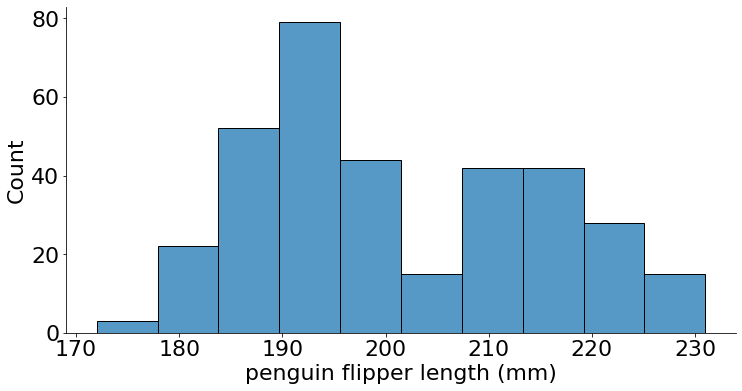

In [7]:
penguins = sns.load_dataset("penguins")
sns.histplot(data=penguins, x="flipper_length_mm")
plt.xlabel("penguin flipper length (mm)")
sns.despine()
#plt.savefig("figures/penguin_flipper_length.svg")

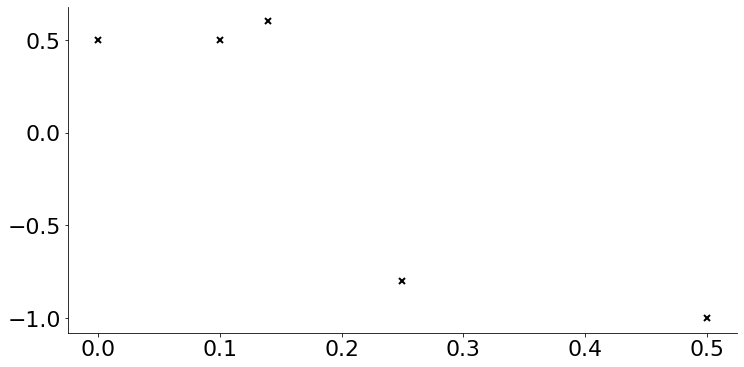

In [4]:
D = np.array([[0, 0.5], [0.1, 0.5], [0.14, 0.6], [0.25, -0.8],  [0.5, -1.]])
D_prime = np.delete(D, 3, axis=0)
X = D[:, 0].reshape(-1, 1)
Y = D[:, 1].reshape(-1, 1)

_ = plt.plot(X, Y, "kx", mew=2)
sns.despine()

In [5]:
def fit_GP(data_arr:np.array):   
    X = data_arr[:, 0].reshape(-1, 1)
    Y = data_arr[:, 1].reshape(-1, 1)
    k = gpflow.kernels.SquaredExponential()
    gp_model = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
    gp_model.likelihood.variance.assign(0.05)
    gp_model.kernel.lengthscales.assign(0.15)
    opt = gpflow.optimizers.Scipy()

    #opt_logs = opt.minimize(gp_model.training_loss, gp_model.trainable_variables, options=dict(maxiter=100))
    return gp_model

In [6]:
d_fit = fit_GP(D)
d_prime_fit = fit_GP(D_prime)

2022-05-24 10:29:58.312200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 10:29:58.312280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-24 10:29:58.312321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-24 10:29:58.314615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-05-24 10:29:58.314670: W tensorflow/stream_executor/platform/default/dso_loader

In [7]:
def plot_predictive_DP(args_d, args_d_prime, num_samples=100, title=""):
    (gp, d) = args_d
    (gp_prime, d_prime) = args_d_prime
    X_prime = d_prime[:, 0].reshape(-1, 1)
    Y_prime = d_prime[:, 1].reshape(-1, 1)
    X = d[:, 0].reshape(-1, 1)
    Y = d[:, 1].reshape(-1, 1)
    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = gp.predict_f(xx)
    mean_prime, var_prime = gp_prime.predict_f(xx)

    ## generate num_samples samples from posterior
    tf.random.set_seed(1)  # for reproducibility
    samples = gp.predict_f_samples(xx, num_samples)  # shape (10, 100, 1)
    samples_prime= gp_prime.predict_f_samples(xx, num_samples)

    ## plot GP D
    plt.figure(figsize=(12, 6))
    d_line = plt.plot(xx, mean, c="maroon", lw=2, label="D", alpha=0.7)
    plt.fill_between(
        xx[:, 0],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color="maroon",
        alpha=0.15,
    )
    plt.plot(xx, samples[:, :, 0].numpy().T, "red", linewidth=0.5, alpha=0.1)

    ## plot GP D'
    d_prime_line = plt.plot(xx, mean_prime, c="#2c0735", lw=2, label="D'", alpha=0.7)
    plt.fill_between(
        xx[:, 0],
        mean_prime[:, 0] - 1.96 * np.sqrt(var_prime[:, 0]),
        mean_prime[:, 0] + 1.96 * np.sqrt(var_prime[:, 0]),
        color="#2c0735",
        alpha=0.1,
    )
    plt.plot(xx, samples_prime[:, :, 0].numpy().T, c="#2c0735", linewidth=0.5, alpha=0.15)

    plt.scatter(X, Y, c='maroon', s=80, alpha=0.8)
    plt.scatter(X_prime, Y_prime, c='black', s=80, alpha=0.8)
    sns.despine()
    #plt.legend(handles=["D", "D'"], loc="lower right")# 
    plt.legend(loc="lower right")
    plt.axis('off')


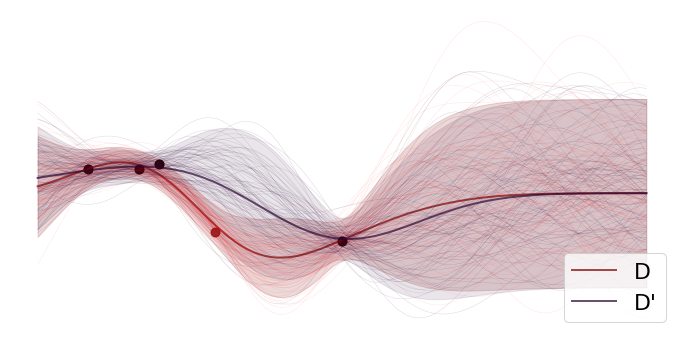

In [8]:
plot_predictive_DP(args_d=(d_fit, D), args_d_prime=(d_prime_fit, D_prime))
plt.savefig("figures/DP_GP.svg")

## LAP PRIVACY LOSS RV

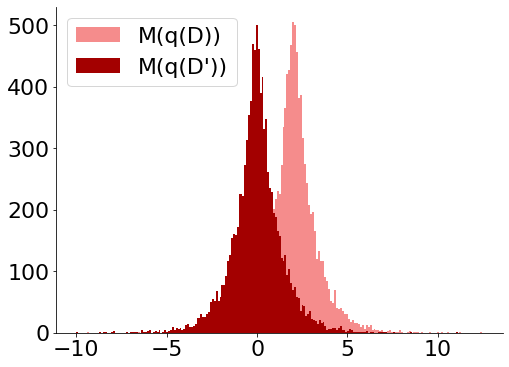

In [14]:
plt.figure(figsize=(8, 6))
qd = np.random.laplace(loc=0, scale=1 / 1, size=(10_000,))
qdd = np.random.laplace(loc=2, scale=1 / 1, size=(10_000,))
plt.hist(qdd, bins=200, color='#f58c8c', label="M(q(D))")
plt.hist(qd, bins=200, color='#a30000', label="M(q(D'))")
sns.despine()
plt.legend(loc='upper left')
plt.savefig("figures/lap_dp.svg")
plt.show()
